# Filtering expanded dataset

## Core Imports

In [1]:
# Generic Imports
import matplotlib.pyplot as plt
import pandas as pd

# File I/O
from pathlib import Path
import csv, json

# Typing and Subclassing
from typing import Iterable, Optional, Union
from dataclasses import dataclass, field

# Cheminformatics
from rdkit import Chem

# Custom imports
from polymerist.rdutils import rdkdraw
from polymerist.smileslib import substructures
from polymerist.monomers import specification

DIM    = 300
ASPECT = 3/2
rdkdraw.set_rdkdraw_size(DIM, ASPECT)
rdkdraw.disable_substruct_highlights()

# Static Paths
RAW_DATA_DIR  = Path('monomer_data_raw')
FMT_DATA_DIR  = Path('monomer_data_formatted')
PROC_DATA_DIR = Path('monomer_data_processed')
RXN_FILES_DIR = Path('poly_rxns')
# RXN_FILES_DIR = Path('rxn_smarts')

## Loading desired dataset

In [2]:
input_data_path = FMT_DATA_DIR / 'nipu_urethanes_FMT.csv'
# input_data_path = FMT_DATA_DIR / '20231114_polyid_data_density_DP2-6 - 1,2 monomers.csv'
# input_data_path = FMT_DATA_DIR / '221010_trainingdata_DP-18_expanded_FMT.csv'
df = pd.read_csv(input_data_path)

## Defining queries for illegal chemistries

In [3]:
illegal_chem_queries = {
    'silicon' : Chem.MolFromSmarts('[Si]'),
    'sulfur'  : Chem.MolFromSmarts('[S]'),
    'metal'   : substructures.SPECIAL_QUERY_MOLS['metal'],
    # 'halogen' : substructures.SPECIAL_QUERY_MOLS['halogen'],
}

## Loading and backmapping premade reaction functional groups and templates

In [4]:
rxn_backmap = { # map NREL dataset mechanism names to pre-made rxn template names
    'amide'     : 'polyamide',
    'carbonate' : 'polycarbonate_phosgene',
    'ester'     : 'polyester',
    'imide'     : 'polyimide',
    'urethane'  : 'polyurethane_isocyanate',
    'NIPU'      : 'polyurethane_nonisocyanate',
    'vinyl'     : 'polyvinyl_head_tail'
}
assert(set(df['mechanism'].unique()).issubset(set(rxn_backmap.keys()))) # verify that we've mapped all reactions

with (RXN_FILES_DIR / 'rxn_backmap.json').open('w') as backmap_file:
    json.dump(rxn_backmap, backmap_file, indent=4)

In [5]:
from polymerist.rdutils.reactions import reactions

with (RXN_FILES_DIR / 'fn_group_smarts.json').open('r') as file:
    fn_group_smarts  = json.load(file)
    
fn_group_queries = { # RDKit Mols generated from SMARTS queries
    group_name : Chem.MolFromSmarts(smarts)
        for group_name, smarts in fn_group_smarts.items()
}

with (RXN_FILES_DIR / 'rxn_groups.json').open('r') as file: # load table of functional group for each reaction
    rxn_groups = json.load(file)

rxns = {
    rxnname : reactions.AnnotatedReaction.from_rxnfile(RXN_FILES_DIR / f'{rxnname}.rxn')
        for rxnname in rxn_groups.keys()
}

rxn_smarts_by_mech = {
    mechanism : rxns[rxnname].to_smarts()
        for mechanism, rxnname in rxn_backmap.items()
}

In [6]:
banned_monomers = [ # monomers which are, for one reason or another, disallowed
    'CC(C)(C)c1cc(c(Oc2ccc(cc2)N(c3ccc(N)cc3)c4ccc(N)cc4)c(c1)C(C)(C)C)C(C)(C)C'  # the extraordinary number of symmetries of this amine ("4-N-(4-aminophenyl)-4-N-[4-(2,4,6-tritert-butylphenoxy)phenyl]benzene-1,4-diamine")... 
]                                                                                 # ...mean it takes impractically long to isomorphism match during the Topology partition step

banned_monomer_queries = {}
for smiles in banned_monomers:
    exp_spi = specification.expanded_SMILES(smiles, assign_map_nums=False)
    banned_monomer_queries[smiles] = Chem.MolFromSmiles(exp_spi, sanitize=False)

## Utility functions

In [7]:
from enum import Enum, auto

@dataclass
class MonomerInfo:
    '''For encapsulating salient info about an individual monomer'''
    smiles        : str
    fn_group_name : str
    IUPAC_name    : str

@dataclass
class MonomersInfo:
    '''For encapsulating information about a collection of reacting monomers'''
    reactant_smiles  : str
    canonical_smiles : str
    polymer_name     : str = field(default_factory=str)
    iupac_names      : list[str] = field(default_factory=list)

class FilterRejectionReason(Enum):
    '''For capturing information about which filtering step a monomer didn't pass'''
    BAD_NUM_MONOMERS      = auto()
    ILLEGAL_ATOMS         = auto()
    NO_RXN_TEMPLATE_MATCH = auto()
    BAD_NUM_FN_GRPS       = auto()
    BANNED_MONOMER        = auto()

In [8]:
from polymerist.monomers import specification
from polymerist.rdutils.bonding import combined_rdmol
from polymerist.genutils.textual.encoding import hash_as_alphanum
from polymerist.smileslib.chemdbqueries import get_property_from_smiles


def process_monomer_input(monomer_smiles : str, rxn_smarts : str, allowed_functionalities : set[int]=None) -> Union[FilterRejectionReason, MonomersInfo]:
    '''For screening and expanding SMILES input to the MD polymer building workflow'''
    # set mutable defaults, initialize objects
    canon_smi = Chem.CanonSmiles(monomer_smiles)
    canon_smi_indiv = canon_smi.split('.')
    if allowed_functionalities is None:
        allowed_functionalities = {2}

    indiv_smiles = monomer_smiles.split('.') # opting for direct string-based approach here rather than RDKit Mol fragmenting for speed, and to avoid clunky str -> Mol -> str conversion
    rxn = reactions.AnnotatedReaction.from_smarts(rxn_smarts)

    # 1) Determine number of distrinct monomers in passed SMILES string
    if len(indiv_smiles) != rxn.GetNumReactantTemplates():
        return FilterRejectionReason.BAD_NUM_MONOMERS
    
    # Generate expanded SMILES string and corresponding RDKit Mol for all monomers
    monomers_by_exp_smiles : dict[str, Chem.Mol] = {}
    exp_smiles_by_monomers : dict[Chem.Mol, str] = {} # reverse lookup to figure out the correct smiles given a molecule
    indiv_monomers         : list[Chem.Mol] = []
    
    for smi in indiv_smiles: # wait to expand SMILES until after count filtering for speed
        exp_smi = specification.expanded_SMILES(smi, assign_map_nums=False)
        monomer = Chem.MolFromSmiles(exp_smi, sanitize=False)

        # 2) Catch monomers with illegal atoms or, if none are present, generate expanded SMILES string and corresponding RDKit Mol for all monomers
        if any(substructures.matching_labels_from_substruct_dict(monomer, illegal_chem_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.ILLEGAL_ATOMS

        # 3) Exclude any monomers which are structurally disallowed
        if any(substructures.matching_labels_from_substruct_dict(monomer, banned_monomer_queries)): # if any illegal atoms are detected in the current monomer, return and exit
            return FilterRejectionReason.BANNED_MONOMER
        
        indiv_monomers.append(monomer)
        monomers_by_exp_smiles[exp_smi] = monomer
        exp_smiles_by_monomers[monomer] = exp_smi

    # 4) Determine if monomer functionalizations match the advertised rxn, and if so in what order they should appear
    ordered_monomers = rxn.valid_reactant_ordering(indiv_monomers)
    if ordered_monomers is None:
        return FilterRejectionReason.NO_RXN_TEMPLATE_MATCH

    # produce monomers based on a valid ordering if one is found
    reactant_smis : list[str] = []
    iupac_names     : list[str] = []

    for i, monomer in enumerate(ordered_monomers):
        # 5) Determine if all monomers are only have the desired functionalization numbers 
        react_templ = rxn.GetReactantTemplate(i)
        if substructures.num_substruct_queries_distinct(monomer, react_templ) not in allowed_functionalities:
            return FilterRejectionReason.BAD_NUM_FN_GRPS
        
        smiles = exp_smiles_by_monomers[monomer]
        reactant_smis.append(smiles)

        # Query IUPAC names for each monomer - NOTE: not done in the monomer expansion loop as the name query is the slowest step and should preferably alled as few times as possible
        iupac_name = get_property_from_smiles(smiles, prop_name='iupac_name') # returns NoneType if no query is found
        if iupac_name is None:
            iupac_name = hash_as_alphanum(canon_smi_indiv[i]) # if no name can be queried, generate hash of name for individual canonicalized SMILES as stand-in 
        iupac_names.append(iupac_name)

    # if a monomer has gotten here, that means it's passed!
    return MonomersInfo(
        reactant_smiles='.'.join(reactant_smis),
        canonical_smiles=canon_smi,
        polymer_name=hash_as_alphanum(canon_smi),  # Produce unique identifier hash from canonical (incomplete) SMILES of monomers as fragments of single mol
        iupac_names=iupac_names
    )

# Filter dataset

## Generate filtered Series (either error codes or MonomerInfo) from initial dataset

In [9]:
from rich.progress import track

targ_df = df
# targ_df = df.head(20)
# targ_df = df[df.mechanism == 'vinyl']

proc_output = []
for (i, row) in track(targ_df.iterrows(), total=len(targ_df), description='Processing SMILES dataset...'):
    proc = process_monomer_input(row.smiles_monomer, rxn_smarts_by_mech[row.mechanism])
    proc_output.append(proc)

proc_output = pd.Series(proc_output) # convert from list to Series, partition by failure state - NOTE: done in pandas to givee access to indices of passed monomers in original frame
rejected = proc_output.map(lambda out : isinstance(out, FilterRejectionReason))
is_valid = ~rejected

Output()

## Expand successful monomers into labelled DataFrame

In [10]:
# extract original data, processed smiles monomers, and reaction info from indices of valid chemistries 
passes_raw = proc_output[is_valid]
passes_index = proc_output.index[is_valid]
passes_orig_data = df.iloc[passes_index].rename(columns={'mechanism' : 'mechanism_original'}, inplace=False) # rename prior mechanism column to free up the label for the assigned reaction name

passes_reactant_info = pd.DataFrame.from_records(passes_raw.map(lambda x : x.__dict__).tolist(), index=passes_index) # tolist() seems to be necessary to avoid weird indexing exceptions
passes_rxn_names  = passes_orig_data['mechanism_original'].map(rxn_backmap).rename('mechanism')           # make the newly-assigned reaction name the "true" mechanism
passes_rxn_smarts = passes_rxn_names.map(lambda rxnname : rxns[rxnname].to_smarts()).rename('reaction_smarts') # changes name to be distinct (name is kept by default after map())

# concatenate all passing data along columns, indexed by mechanism and hashname
passes = pd.concat([passes_reactant_info, passes_rxn_names, passes_rxn_smarts, passes_orig_data], axis=1)
passes.set_index(['mechanism', 'polymer_name'], inplace=True)
passes

reactant_smiles  \
mechanism                  polymer_name                                                                
polyurethane_nonisocyanate vl-PLN0bPA2tzuKT3JB7YQ  [H]-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(...   
                           sKEMIdfcMiFe18aNI2Z-ww  [H]-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(...   
                           NIbNm49MnycXz0lh7f4HtQ  [H]-[C](-[H])(-[O]-[C](-[H])(-[H])-[C]1(-[H])-...   
                           zf53ra19MfoVs1yNmHleqg  [H]-[C](-[H])(-[O]-[C](-[H])(-[H])-[C]1(-[H])-...   
                           B5IBuyC_m2byA9hty44ioQ  [H]-[C](-[H])(-[H])-[C](-[H])(-[H])-[C](-[H])(...   
...                                                                                              ...   
polyurethane_isocyanate    gY6V1-UHX6G_zFY7My9sKA  [H]-[C](-[H])(-[N]=[C]=[O])-[C](-[H])(-[H])-[C...   
                           CrOScU8xBe76G9vvTa5HgA  [H]-[C]1=[C](-[N]=[C]=[O])-[C](-[H])=[C](-[H])...   
                           yjU1SBlPBhkC6xhjiVT9-g  [H]-[C](-[H])(-[N]=[C]=[O])-[C](-[H])(-[H])-[C...   
                           WxHoFQhYXdUbNLa4uRZZ5Q  [H]-[C](-[H])(-[N]=[C]=[O])-[C](-[H])(-[H])-[C...   
                           E0pcQoLp3ltjWNM_7Z2j5A  [H]-[C](-[H])(-[H])-[C]1(-[C](-[H])(-[H])-[H])...   

                                                                                    canonical_smiles  \
mechanism                  polymer_name                                                                
polyurethane_nonisocyanate vl-PLN0bPA2tzuKT3JB7YQ  CCCCCCCC1C(CCCCC)CCC(CCCCCCCCC(=O)OCC2COC(=O)O...   
                           sKEMIdfcMiFe18aNI2Z-ww  CCCCCCCC1C(CCCCC)CCC(CCCCCCCCC(=O)OCC2COC(=O)O...   
                           NIbNm49MnycXz0lh7f4HtQ  CCCCCCNC(=O)C(O)(CC(=O)NCCCCCCN)CC(=O)NCCCCCCN...   
                           zf53ra19MfoVs1yNmHleqg  CCCCCCCC1C(CCCCC)CCC(CCCCCCCCC(=O)NCCCCNC(=O)C...   
                           B5IBuyC_m2byA9hty44ioQ  CCCCCCCC1C(CCCCC)CCC(CCCCCCCCC(=O)OCC2COC(=O)O...   
...                                                                                              ...   
polyurethane_isocyanate    gY6V1-UHX6G_zFY7My9sKA                          O=C=NCCCCCCN=C=O.OCCCCCCO   
                           CrOScU8xBe76G9vvTa5HgA               O=C=Nc1ccc(Cc2ccc(N=C=O)cc2)cc1.OCCO   
                           yjU1SBlPBhkC6xhjiVT9-g                            O=C=NCCCCCCN=C=O.OCCCCO   
                           WxHoFQhYXdUbNLa4uRZZ5Q                              O=C=NCCCCCCN=C=O.OCCO   
                           E0pcQoLp3ltjWNM_7Z2j5A      CC1(C)CC(N=C=O)CC(C)(CN=C=O)C1.OCC1CCC(CO)CC1   

                                                                                         iupac_names  \
mechanism                  polymer_name                                                                
polyurethane_nonisocyanate vl-PLN0bPA2tzuKT3JB7YQ       [v35HIbEmMbbN8eIfDhdNzw, butane-1,4-diamine]   
                           sKEMIdfcMiFe18aNI2Z-ww  [v35HIbEmMbbN8eIfDhdNzw, N-(3-aminopropyl)prop...   
                           NIbNm49MnycXz0lh7f4HtQ  [4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hexoxy...   
                           zf53ra19MfoVs1yNmHleqg  [4-[6-[(2-oxo-1,3-dioxolan-4-yl)methoxy]hexoxy...   
                           B5IBuyC_m2byA9hty44ioQ  [v35HIbEmMbbN8eIfDhdNzw, 2-[2-(2-aminoethoxy)e...   
...                                                                                              ...   
polyurethane_isocyanate    gY6V1-UHX6G_zFY7My9sKA          [1,6-Diisocyanatohexane, HEXANE-1,6-DIOL]   
                           CrOScU8xBe76G9vvTa5HgA  [1-isocyanato-4-[(4-isocyanatophenyl)methyl]be...   
                           yjU1SBlPBhkC6xhjiVT9-g          [1,6-Diisocyanatohexane, Butane-1,4-diol]   
                           WxHoFQhYXdUbNLa4uRZZ5Q          [1,6-Diisocyanatohexane, Ethane-1,2-diol]   
                           E0pcQoLp3ltjWNM_7Z2j5A  [5-Isocyanato-1-(isocyanatomethyl)-1,3,3-trime...   

                          

## Show distribution of failure cases

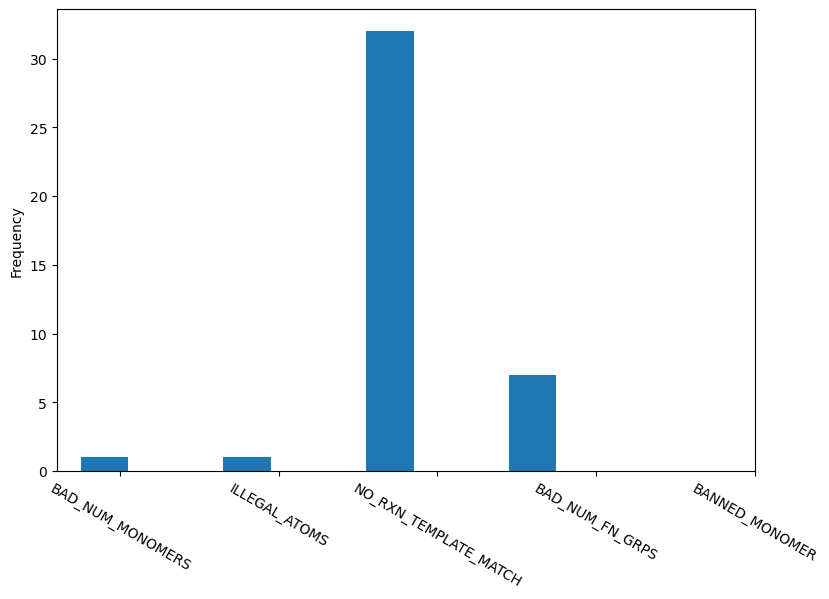

In [11]:
dim = 6
aspect= 3/2

plt.figure(figsize=(dim*aspect, dim))

rejects_reasons = proc_output[rejected]
rejects     = rejects_reasons.map(lambda r : r.name)
rejects_ids = rejects_reasons.map(lambda x : x.value)

ax = rejects_ids.plot(kind='hist')
ax.set_xticks([(i.value + 0.25) for i in FilterRejectionReason])
ax.set_xticklabels([i.name for i in FilterRejectionReason], rotation=-30)

plt.show()

## Save filtered DataFrame for next steps to avoid reprocessing

In [12]:
from polymerist.genutils.fileutils.pathutils import assemble_path, dotless

PROC_DATA_DIR.mkdir(exist_ok=True)
clean_input_stem = input_data_path.stem.removesuffix('_FMT')
extension = dotless(input_data_path)

# save filtered dataset to filtered directory to store caclulations
passes_path  = assemble_path(PROC_DATA_DIR, input_data_path.stem.replace(' ', '_'), postfix='FILTERED_NEWSTYLE', extension=extension)
passes.to_csv(passes_path)

rejects_path = assemble_path(PROC_DATA_DIR, input_data_path.stem.replace(' ', '_'), postfix='REJECTED_NEWSTYLE', extension=extension)
rejects.to_csv(rejects_path)